In [16]:
# !conda install -n vitinf ipykernel --update-deps --force-reinstall -y
!pip install -q transformers
!pip install matplotlib
# !pip3 install torch torchvision

  Using cached contourpy-1.2.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.8 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.46.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (156 kB)
  Using cached kiwisolver-1.4.5-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (6.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 116.3 MB/s eta 0:00:0000:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.7/310.7 kB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 122.0 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 84.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 kB 10.5 MB/s eta 0:00:00


In [8]:
!pwd

/storage/ice1/8/1/bgoyal7/HML/Numerosity-ViT


In [2]:
import torch

import transformers
from transformers import ViTForImageClassification


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
model.to(device)

/home/hice1/bgoyal7/.conda/envs/vitinf/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
config.json: 100%|██████████| 69.7k/69.7k [00:00<00:00, 125MB/s]
model.safetensors: 100%|██████████| 346M/346M [00:00<00:00, 459MB/s] 


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [46]:
from transformers import ViTImageProcessor
from PIL import Image
i1 = Image.open('/home/hice1/bgoyal7/scratch/HML/experiment_data/exp1_equal_area_circles/1/1_1.png').convert("RGB")
i2 = Image.open('/home/hice1/bgoyal7/scratch/HML/experiment_data/exp1_equal_area_circles/1/1_2.png').convert("RGB")
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
ls = [i1 for _ in range(2)]
tempinputs = processor(images=ls, return_tensors="pt").to(device)

In [47]:
print((tempinputs.data['pixel_values'].shape))

torch.Size([2, 3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


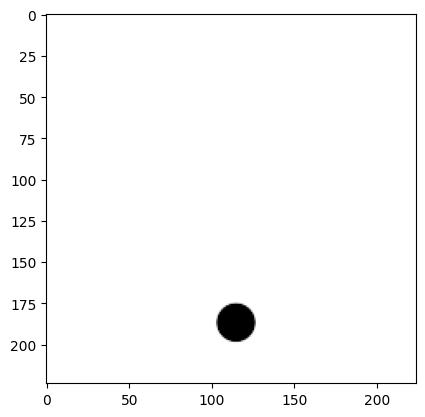

In [17]:
import matplotlib.pyplot as plt
plt.imshow(pixel_values.cpu().squeeze().permute(1, 2, 0))

In [50]:
with torch.no_grad():
  # curoutput = model(pixel_values, output_attentions = True, output_hidden_states = True)
  batchoutput = model(tempinputs.pixel_values, output_attentions = True, output_hidden_states = True)
# logits = outputs.logits
# logits.shape
def get_cls_attention(outputs): 
    comp = ([torch.sum(i.cpu(), dim = 1) for i in outputs.attentions])
    overall = torch.stack(comp).sum(dim=0)
    imversion = np.kron(overall[:, 1:, 0].reshape((-1, 14, 14)), np.ones((1, 16, 16)))
    return overall, imversion, comp
# att = torch.sum(comp, )
# print(comp.shape)
  # plt.plot(i.cpu().squeeze()[0])
# print(type(outputs))
# shapes.clear()
# for i in outputs.hidden_states:
#   shapes.append(i.shape)
# print(shapes)
# plt.imshow(pixel_values.cpu().squeeze().permute(1, 2, 0))
# plt.imshow(comp, alpha=0.5)
# plt.imshow(comp)

In [51]:
garb_overall, garb_imversion, garb_comp = get_cls_attention(batchoutput)
print(garb_overall.shape)
print(garb_imversion.shape)
print(garb_comp[0].shape)
print(len(garb_comp))

torch.Size([2, 197, 197])
(2, 224, 224)
torch.Size([2, 197, 197])
12


In [ ]:
print(batchoutput.attentions[0].shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


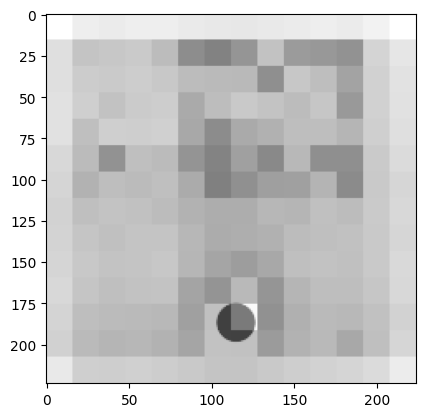

In [53]:
import numpy as np
import matplotlib.pyplot as plt

# Load the two images

# Create a figure and axes
fig, ax = plt.subplots()

# Display the first image
ax.imshow(pixel_values.cpu().squeeze().permute(1, 2, 0))

# Overlay the second image with transparency
ax.imshow(imversion, alpha=0.5, cmap='gray')

# Save the overlaid image to a PNG file
plt.savefig('sample.png')


In [59]:
from torchvision import transforms
to_pil = transforms.ToPILImage()
img_pil = to_pil(pixel_values.cpu().squeeze().permute(1, 2, 0))
img2_pil = 

AttributeError: 'Figure' object has no attribute 'imshow'

In [54]:
# torch.save(dictionary, 'file_name.pt')
torch.save(curoutput.hidden_states, 'file_name.pt')


In [64]:
a = torch.tensor([[1, 2, 3], [4, 5, 6]])
print(a[0].shape)

torch.Size([3])


In [56]:
# for i in range(len(curoutput.hidden_states)):
#   print(curoutput.hidden_states[i].shape)
#   print(garb_tensors[i].shape)
#   print(torch.all(torch.eq(curoutput.hidden_states[i], garb_tensors[i])))

torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
tensor(True)
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
tensor(True)
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
tensor(True)
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
tensor(True)
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
tensor(True)
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
tensor(True)
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
tensor(True)
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
tensor(True)
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
tensor(True)
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
tensor(True)
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
tensor(True)
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
tensor(True)
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
tensor(True)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


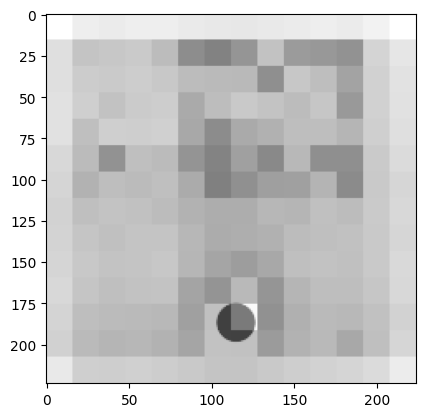

In [32]:
plt.imshow(pixel_values.cpu().squeeze().permute(1, 2, 0))
overall, imversion, comp = get_cls_attention(curoutput)
plt.imshow(imversion, cmap='gray', alpha=0.5)
#11, 7


In [34]:
for i in curoutput.hidden_states: 
    print(i.shape)

torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])


In [35]:
print(overall[11, 7])
print(overall[11, 8])
print(overall[11, 6])


tensor(0.7067)
tensor(0.7635)
tensor(0.6627)
